# 랭그래프 활용

- 웹 검색 결과를 활용하여 일반적인 질문이나 최신 정보가 필요한 질문에 답변하기
- 이전 대화와 사용자 설정을 저장하여 대화의 맥락 유지하기
- 인간의 개임이 필요한 복잡한 질문의 경우, 인간에게 라우팅하기
- 필요에 따라 커스텀 상태 값을 사용하여 챗봇의 동작을 유연하게 제어하기
- 이전 대화로 되돌아가 수정하는 기능 지원하기


In [10]:
from dotenv import load_dotenv
load_dotenv()

True

- add_messages 기능을 활용하여 메시지를 누적합니다.


In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# 실습에서 사용할 그래프의 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 실습에서 사용할 그래프 인스턴스
graph_builder = StateGraph(State)

## 2.1 루프 구현하기

- 챗봇 노드를 추가합니다.
- 이 노드는 LLM이 사용자의 질의를 받아 응답을 생성하는 역할을 합니다.


In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

# 챗봇 함수 정의
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# 챗봇 노드 정의
graph_builder.add_node("chatbot", chatbot)

- 그래프의 시작과 종료를 나타내는 진입지점, 종료지점을 지정합니다.


In [5]:
#진입지점
graph_builder.add_edge(START, "chatbot")

# 종료지점
graph_builder.add_edge("chatbot", END)

- 그래프가 완성되었으면 compile() 함수를 호출하여 실행 가능한 형태로 변환합니다.
- 정의한 노드와 흐름을 실제 실행할 수 있는 구조로 만드는 것을 의미합니다.


In [6]:
graph = graph_builder.compile()

- 사용자의 입력은 graph.stream() 함수를 통해 미리 구성한 챗봇 워크플로우에 전달하면 되며, 생성된 응답은 event에 누적되어 확인할 수 있습니다.


In [8]:
while True:
    #사용자의 질문 입력받기
    user_input = input("User: ")
    print("User: ", user_input)

    #사용자가 quit 또는 exit, q를 입력하였다면 루프 종료
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Exiting the chatbot. Goodbye!")
        break

    # 사용자의 입력을 그래프에 전달하여 정의된 흐름 실행
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


User:  너는 누구야?
Assistant: 저는 AI 언어 모델인 ChatGPT입니다. 질문에 답하고, 정보 제공, 대화에 참여하는 등의 역할을 합니다. 무엇을 도와드릴까요?
User:  반가워!
Assistant: 반가워요! 어떻게 도와드릴까요?
User:  exit
Exiting the chatbot. Goodbye!


- 현재까지 구성한 그래프를 시각화합니다.
- draw_mermaid_png() 함수를 이용해 이미지로 출력할 수 있습니다.


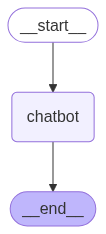

In [9]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [1]:
from langchain_community.tools.tavily_search import TavilySearchResults

# Tavily 검색 엔진을 도구로 정의
tool = TavilySearchResults(max_results=2)
tools  = [tool]

#호출 예시
r = tool.invoke("내일 대한민국 서울의 날씨는?")
r

[{'title': '서울 실시간 날씨 정보 | 서울 공식 관광정보 웹사이트',
  'url': 'https://korean.visitseoul.net/weather',
  'content': '## [visitseoul.net](https://korean.visitseoul.net "visitseoul.net")\n\n#### 3일 예보\n\n3일 예보 : 날짜, 날씨, 최저/최고기온(℃), 강수확률\n\n|  |  |  |  |\n| --- | --- | --- | --- |\n| 날짜 | **오늘 : 2025-05-30** | **내일 : 2025-05-31** | **모레 : 2025-06-01** |\n| 날씨 | 맑음 | 맑음 | 구름많음 |\n| 맑음 | 맑음 | 구름많음 |\n| 최저/최고기온 (℃) | 16℃ / 0℃ | 16℃ / 29℃ | 16℃ / 29℃ |\n| 강수확률 | 0% / 0% | 0% / 0% | - | [...] |  |  |  |  |  |  |\n| --- | --- | --- | --- | --- | --- |\n| 날짜 | **2025-05-30** | **2025-05-31** | **2025-06-01** | **2025-06-02** | **2025-06-03** |\n| 날씨 | 맑음 | 맑음 | 구름많음 | 흐림 | 흐림 |\n| 맑음 | 맑음 | 구름많음 | 흐림 | 흐림 |\n| 최저/최고기온 (℃) | 16℃ / 0℃ | 16℃ / 29℃ | 16℃ / 29℃ | 18℃ / 23℃ | 17℃ / 23℃ |',
  'score': 0.81347597},
 {'title': '서울특별시, 서울시, 대한민국 3일 날씨 예보 - AccuWeather',
  'url': 'https://www.accuweather.com/ko/kr/seoul/226081/weather-forecast/226081',
  'content': '3%](https://www.accuweather.com/ko/kr/seoul/2260

- 정의한 도구를 llm.bind_tools(tools) 함수를 사용하여 LLM과 연결합니다.


In [2]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

#그래프 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

#그래프 정의
graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")
#오픈AI 클래이언트에 Tavily 검색 엔진 도구 할당
llm_with_tools = llm.bind_tools(tools)

# 챗봇 함수 정의
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 그래프에 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

- 이제 챗봇은 LLM의 응답에 따라 두 가지 상황에 대응해야 합니다.
- LLM이 도구를 활용해야 한다고 판단하고 도구에 필요한 파라미터를 응답한 경우 도구를 호출해야 합니다.
- LLM이 단순 답변을 응답한 경우 사용자에게 응답을 반환하고 종료해야 합니다.


In [3]:
import json

from langchain_core.messages import ToolMessage

#도구 노드를 사용할 클래스
class BasicToolNode:
    #도구 노드에서 사용할 초기 파라미터 정의
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    #도구 노드가 호출될 때의 행동 정의
    def __call__(self, inputs: dict):
        #입력된 상태의 가장 마지막 메시지 획득
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 메시지의 tool_calls에 도구 정보가 존재한다면 이를 활용해 도구 호출
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(tool_call["args"])

            #도구 호출 결과를 ToolMessage로 정의하여 출력값에 저장
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result, ensure_ascii=False),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        #출력값을 상태값 형식에 맞춰 반환
        return {"messages": outputs}

#도구 노드 정의
tool_node = BasicToolNode(tools=[tool])
#도구 노드 그래프에 추가
graph_builder.add_node("tools", tool_node)



- 도구 노드는 항상 실행되는 것이 아니라, LLM응답에 도구 호출 정보, 즉 tool_calls가 포함된 경우에만 활성화되어야 합니다.
- hasattr(ai_message, "tool_calls")와 len(ai_messages.tool_calls) > 0 조건을 검사하여 LLM 응답에 tool_calls 응답이 있으면 도구 노드를 의마하는 tools를, 없다면 종료를 의미하는 ** end ** 를 반환합니다.


In [4]:
from typing import Literal

#도구 노드 호출 여부를 결정하는 함수 정의
def route_tools(state: State) -> Literal["tools", END]:
    #상태값의 최근 메시지를 정의
    if isinstance(state, list):
        ai_message = state[-1]
    elif message := state.get("messages", []):
        ai_message = message[-1]
    else:
        raise ValueError("No messages found in input state to tool_edge: {state}")

    # 가장 최근 메시지에 tool_calls 속성이 있다면 tools 노드를 아니라면 종료지점을 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

# 챗봇 노드 조건부 에지를 정의
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools",
     END: END}
)

- 도구 노드가 실행된 이후에는 다시 챗봇 노드로 이동하여 검색 결과를 바탕으로 최종 응답을 생성합니다.


In [5]:
# 도구 노드와 챗봇 노드 연결
graph_builder.add_edge("tools", "chatbot")
# 진입지점으로 챗봇 노드 지정
graph_builder.add_edge(START, "chatbot")

- 챗봇 그래프를 확인해봅니다.


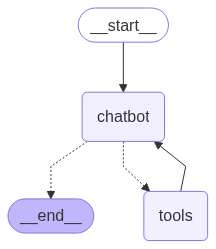

In [7]:
from IPython.display import Image, display
#그래프 컴파일
graph = graph_builder.compile()
#그래프 이미지화
display(Image(graph.get_graph().draw_mermaid_png()))

## 2.3 스트리밍

- 랭그래프에서 실시간으로 데이터를 지속적으로 전송하는 스트리밍 기능을 지원합니다.
- 이 기능을 활용하면 대규모 작업이나 연산이 진행 중일 때도 중간 결과를 즉시 확인할 수 있으며, 전체 결과가 준비되기 전에도 사용자와 상호작용할 수 있습니다.
- 스트리밍은 graph.stream() 함수를 호출 할때 stream_mode 파라미터 값을 다음과 같이 지정해 동작 방식을 선택할 수 있습니다.
  - values: 각 노드가 실행된 후, 그래프의 전체 상태를 실시간으로 반환합니다. 전체 워크플로우의 상태 변화를 추적할 때 유용합니다.
  - updates: 각 노드가 실행된 후, 상태값에 어떤 변경이 발생했는지만 반환합니다. 변경된 부분만 빠르게 확인할 수 있습니다.


In [11]:
from langchain_core.messages import BaseMessage

while True:
    #사용자 질문 입력받기
    user_input = input("User: ")
    print("User: ", user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Exiting the chatbot. Goodbye!")
        break

    #업데이트된 내용을 확인할 수 있는 그래프 스트리밍 정의
    events = graph.stream({"messages": [("user", user_input)]}, stream_mode="updates")

    #그래프 이벤트 내의 메시지를 출력
    for event in events:
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)


User:  24년 9월 9일 서울 날씨
Assistant: 
Assistant: [{"title": "[날씨] 2024년 9월 9일 날씨 / 아주TV X 케이웨더 - YouTube", "url": "https://www.youtube.com/watch?v=xO8yHWbubHc", "content": "[날씨] 2024년 9월 9일 날씨 / 아주TV X 케이웨더\n아주ABC\n64500 subscribers\n6 likes\n198 views\n9 Sep 2024\n안녕하세요 케이웨더 라이프 스타일 예보 신지수입니다.\n\n\n현재 전국이 대체로 구름 많은 가운데 늦은 더위가 이어지고 있는데요.\n\n높은 기온에 대기가 불안정해지면서 오늘 저녁까지 일부 내륙은 5~30mm의 소나기가 지나는 곳이 있겠습니다.\n\n화요일인 내일도 전국이 구름 많겠고 제주도는 저녁부터 비가 내리겠습니다.\n\n서울의 낮 기온은 34도까지 오르면서 늦더위가 계속되겠고요.\n\n서울을 비롯한 곳곳으로 최저 기온이 열대야 기준인 25도 안팎을 보이면서 다시 밤사이 더위가 나타날 가능성이 있습니다.\n\n더위에 지치지 않도록 건강 관리에 유의하셔야겠습니다.\n\n다음은 자세한 지역별 날씨입니다. 중부지방 아침 기온 서울과 청주 25도로 출발해 낮에는 서울과 대전이 34도로 무덥겠습니다.\n\n동해안 지방은 강릉의 아침 기온 22도 보이겠고, 낮에는 강릉과 속초 30도 예상됩니다.\n\n남부지방의 아침 기온은 광주 24도, 대구 23도로 시작해 낮 기온 광주와 대구 34도까지 오르겠습니다.\n\n바다의 물결은 서해와 남해상에서 최고 3~3.5m로 높게 일겠습니다.\n\n목요일 중부지방을 중심으로 비가 내리면서 주 후반으로 갈수록 더위가 한풀 꺾이겠습니다.\n\n\n날씨였습니다.\n\n\n신지수 기상캐스터\n\n\n#날씨  #아주경제 #아주tv #소나기 #늦더위 #서울날씨 #열대야 #제주날씨 #나절예보 #오늘날씨 #내일날씨 #주간날씨 #케이웨더 #라이프스타일 #예보\n1 comments\n

- 스트림 모드를 update로 지정했기 때문에 Assiatant 에 출력되는 결과는 매번 상태가 변경될 때마다 업데이트된 마지막 메시지를 실시간으로 보여줍니다.
- 따라서 전체 대화 내역이 아니라, 최신 응답만을 확인할 수 있습니다.
